# Reciprocal sqrt

https://ajcr.net/fast-inverse-square-root-python/

In [118]:
rd = '\033[91m'
gr = '\033[92m'
yl = '\033[93m'
bl = '\033[94m'
pk = '\033[95m'
tl = '\033[96m'
gy = '\033[97m'
bk = '\033[0m'

import time
import math
N =  1_000_000
a = [i for i in range(1, N)]
b = []
timing = {}

In [119]:
t1 = time.time()
b = [1.0/math.sqrt(x) for x in a]
t2 = time.time()
timing[f'BruteForceLoopExact'] = N/(t2-t1)
print(f"elapsed {rd}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 16,121,955.3 iter/sec


[1.0, 0.7071067811865475, 0.5773502691896258, 0.5, 0.4472135954999579]

# Apply imprecise Newton Fast approx

Adapted from wikipedia article about fast inverse square root

- [Wikipedia:_Fast_inverse_square_root](https://en.wikipedia.org/wiki/Fast_inverse_square_root)

And excellent blog write up by ajcr
- [acjr.net:The_Fast_Inverse_Square_Root_method_in_Python](https://ajcr.net/fast-inverse-square-root-python/)
- This article, after comparing several mehtods for computing reciprocal sqrt on **single value** recommends just using:
```python
a**-.5
```

Lets try vectorizing this function which **appoximates reciprocal sqrt using newton method**

In [120]:
from ctypes import c_float, c_int32, cast, byref, POINTER
import time

def ctypes_isqrt(number):  # operates on single value at a time
    threehalfs = 1.5
    x2 = number * 0.5
    y = c_float(number)

    i = cast(byref(y), POINTER(c_int32)).contents.value
    i = c_int32(0x5f3759df - (i >> 1))
    y = cast(byref(i), POINTER(c_float)).contents.value

    y = y * (1.5 - (x2 * y * y))
    return y

In [121]:
try:
    b = ctypes_isqrt(a)
except:
    print("Can't handle list or ndarray - just single value")

Can't handle list or ndarray - just single value


In [122]:
t1 = time.time()
b = []
for i in range(1,  N ):
    b.append(ctypes_isqrt(i))
t2 = time.time()
timing[f'FRSNewtonLoop'] = N/(t2-t1)
print(f"elapsed {rd}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 724,303.3 iter/sec


[0.9983071495847821,
 0.7069300386983334,
 0.576846835782431,
 0.49915357479239103,
 0.4471410099094477]

# Assume we will do NumPy coversion 

for rest of cells in notebook

In [123]:
import time
import numpy as np

a = np.array([i for i in range(1,     N)])
a = np.expand_dims(a, axis = 0)  # make the array the right sahpe for use by apply

### NumPy apply (vectorize along axis)

In [124]:
t1 = time.time()
b = np.apply_along_axis(ctypes_isqrt, 0, a)
t2 = time.time()
timing['FRSNewtonVectorize'] = N/(t2-t1)
print(f"elapsed {rd}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 190,281.8 iter/sec


array([[9.98307150e-01, 7.06930039e-01, 5.76846836e-01, ...,
        9.98306080e-04, 9.98305582e-04, 9.98305085e-04]])

# Cython Newton Approximation Method

https://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html

In [125]:
import numpy as np
a = np.array([i for i in range(1, N)])
a = np.expand_dims(a, axis = 0)  # make the array the right sahpe for use by apply


### Time compute for single value

In [126]:
from cython_NewtonRecipSqrt import ctypes_nbsqrt
t1 = time.time()
print("estimate 1/sqrt(16)", ctypes_nbsqrt(16) ) # FOr a single value
t2 = time.time()
print(f"elapsed single calc {(t2-t1):,.1f} sec")


estimate 1/sqrt(16) 0.24957678739619552
elapsed single calc 0.0 sec


In [127]:
t1 = time.time()
b = np.apply_along_axis(ctypes_nbsqrt, 0, a)
t2 = time.time()
timing['CythonFRSNewtonApply'] = N/(t2-t1)
print(f"elapsed {rd}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 169,960.6 iter/sec


array([[9.98307150e-01, 7.06930039e-01, 5.76846836e-01, ...,
        9.98306080e-04, 9.98305582e-04, 9.98305085e-04]])

In [128]:
# ctypes_isqrt(a)   #error

# Cython Exact  Method

```python
y = x**-5
```

In [129]:
from cython_Exact import ctypes_Exsqrt


In [130]:
t1 = time.time()
b = ctypes_Exsqrt(a)
t2 = time.time()
timing['CythonExact'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 90,316,623.6 iter/sec


array([[1.        , 0.70710678, 0.57735027, ..., 0.001     , 0.001     ,
        0.001     ]])

# Numba Exact approach
https://numba.pydata.org/numba-doc/latest/user/jit.html

In [131]:
import numba
import numpy as np
N = 100_000_000
a = np.array([i for i in range(1, N)])
#a = np.expand_dims(a, axis = 0)  # make the array the right sahpe for use by apply

@numba.njit
def ctypes_nbsqrt(number):  # operates on single value at a time
  return number ** -0.5

In [132]:
t1 = time.time()
ctypes_nbsqrt(a)
t2 = time.time()
timing['ExactNumba'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 105,971,974.8 iter/sec


array([[1.        , 0.70710678, 0.57735027, ..., 0.001     , 0.001     ,
        0.001     ]])

# Assume we have converted "a" to NumPy

In [133]:
import numpy as np
a = np.array([i for i in range(1, N)])

### Compose NumPy reciprocal and NumPy sqrt

In [134]:
t1 = time.time()
b = np.reciprocal(np.sqrt(a))
t2 = time.time()
timing['ExactNP_recipSqrt'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 500,196,653.4 iter/sec


array([1.        , 0.70710678, 0.57735027, 0.5       , 0.4472136 ])

# Simple minded a**-.5

In [135]:
t1 = time.time()
b = a**-.5
t2 = time.time()
timing['ExactNP_a**-.5'] = N/(t2-t1)
print(f"elapsed {gr}{N/(t2-t1):,.1f} iter/sec{bk}")
b[:5]  # aproximate answer

elapsed 97,695,676.5 iter/sec


array([1.        , 0.70710678, 0.57735027, 0.5       , 0.4472136 ])

Speedup : 2943 X


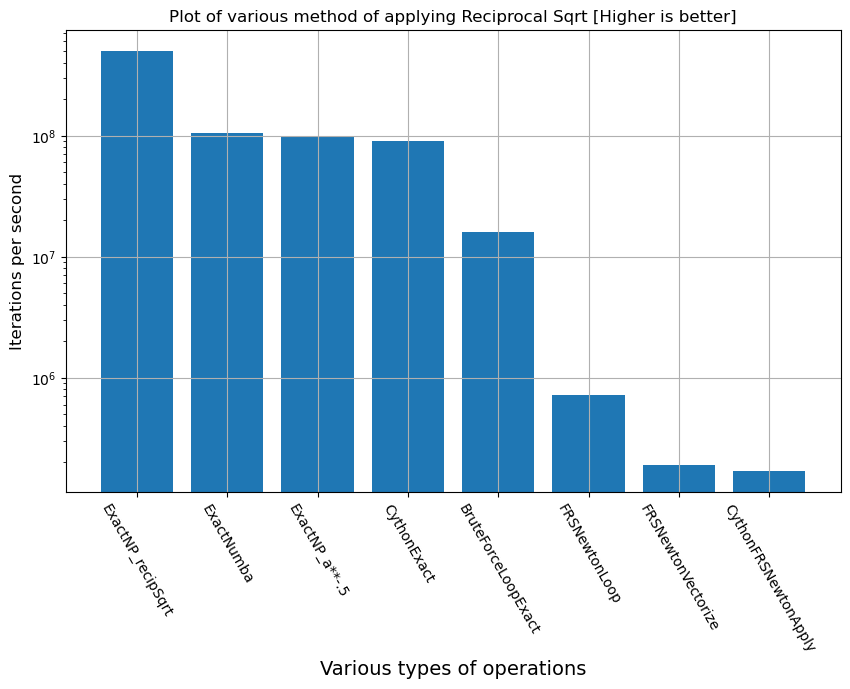

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title("Plot of various method of applying Reciprocal Sqrt [Higher is better]")
plt.ylabel("Iterations per second",fontsize=12)
plt.xlabel("Various types of operations",fontsize=14)
plt.grid(True)
plt.yscale('log')
plt.xticks(rotation=-60)
timingH = dict(sorted(timing.items(), key=lambda x:x[1], reverse=True))
plt.bar(x = range(len(timingH)), height=timingH.values(), align='center', tick_label=list(timingH.keys()))
short = min(list(timingH.values()))
long = max(list(timingH.values()))
print('Speedup : {:4.0f} X'.format(long/short))